In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import models, layers
import cv2
import os
from imutils import paths
import imutils
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import PIL
from PIL import Image
from model_s import SimplePreprocessor, AnimalsDatasetManager, DefaultModel
from keras.applications.vgg16 import VGG16
from tensorflow.keras.losses import CategoricalCrossentropy

In [2]:
def create_label_folder_dict(adir):
    sub_folders= [folder for folder in os.listdir(adir)
                  if os.path.isdir(os.path.join(adir, folder))]
    label_folder_dict= dict()
    for folder in sub_folders:
        item= {folder: os.path.abspath(os.path.join(adir, folder))}
        label_folder_dict.update(item)
    return label_folder_dict

In [3]:
label_folder_dict= create_label_folder_dict("./datasets/Animals")

In [4]:
sp = SimplePreprocessor(width=64, height=64)
data_manager = AnimalsDatasetManager([sp])
data_manager.load(label_folder_dict, verbose=0)
data_manager.process_data_label()
data_manager.train_valid_test_split()

butterfiles 500
cats 501
chickens 500
cows 500
dogs 501
elephants 500
fishes 500
horses 500
lions 500
spiders 500


(64, 64, 3)


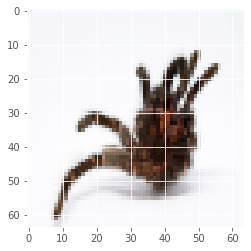

In [10]:
print(data_manager.X_train[0].shape)
plt.imshow(data_manager.X_train[0])

In [11]:
X_train = data_manager.X_train
y_train = data_manager.y_train
X_valid = data_manager.X_valid
y_valid = data_manager.y_valid
y_train_hot = tf.one_hot(data_manager.y_train,10)
y_valid_hot = tf.one_hot(data_manager.y_valid,10)
y_test_hot = tf.one_hot(data_manager.y_test,10)

In [12]:
img = Image.open('./datasets/Animals/butterfiles/e030b20a20e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg')
lr_img = np.array(img)
lr_img.shape
#img.show()

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 30, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
image = np.expand_dims(plt.imread('./datasets/Animals/butterfiles/e030b20a20e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg'),0)
#plt.imshow(image[0])

aug_iter = datagen.flow(image)

aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(30)]

plotImages(aug_images)

NameError: name 'datagen' is not defined

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1, 
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip = True)

datagen.fit(X_train)
it = datagen.flow(X_train, y_train_hot, batch_size=16)


In [14]:
class FCHeadNet:
    def build(base_model, n_classes=10, D=256): # initialize the head model that will be placed on top of he base, then add a FC layer
        base_model.trainable= False
        head_model = base_model.output
        head_model = tf.keras.layers.Flatten(name="flatten")(head_model)
        head_model = tf.keras.layers.Dense(D, activation="relu")(head_model)
        head_model = tf.keras.layers.Dropout(0.4)(head_model)
        # add a softmax layer
        head_model = tf.keras.layers.Dense(n_classes, activation="softmax")(head_model)
        return head_model

In [15]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

Input_Layer = layers.Input(shape=(64, 64, 3))

In [17]:
from tensorflow.keras.applications import VGG16

nets = 5
model = [0] *nets

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

Input_Layer = layers.Input(shape=(64, 64, 3))

for i in range(nets):
    VGG_base = VGG16(input_tensor=Input_Layer,include_top=False,weights="imagenet")
    VGG_base.trainable = False

    head_model = FCHeadNet.build(VGG_base, 10, 256)
    VGG16_model = tf.keras.models.Model(inputs=VGG_base.input, outputs=head_model)
    
    loss = CategoricalCrossentropy(label_smoothing=0.1)
    opt = tf.keras.optimizers.RMSprop(lr=0.001)
    VGG16_model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])
    
    model[i] = VGG16_model

In [21]:
history = [0] *nets
epochs = 7
for j in range(1):
    print(j)
    history[j] = model[j].fit(it,
          validation_data = (data_manager.X_valid,y_valid_hot),
          callbacks=[earlystopping],
          epochs=10,
          batch_size = 32,verbose = 1)


0
Epoch 1/10
250/250 [==============================] - 39s 155ms/step - loss: 1.3310 - accuracy: 0.6475 - val_loss: 1.3280 - val_accuracy: 0.6320
Epoch 2/10
250/250 [==============================] - 39s 156ms/step - loss: 1.3155 - accuracy: 0.6575 - val_loss: 1.3305 - val_accuracy: 0.6180
Epoch 3/10
250/250 [==============================] - 39s 156ms/step - loss: 1.2979 - accuracy: 0.6653 - val_loss: 1.3144 - val_accuracy: 0.6440
Epoch 4/10
250/250 [==============================] - 39s 156ms/step - loss: 1.2758 - accuracy: 0.6733 - val_loss: 1.3097 - val_accuracy: 0.6320
Epoch 5/10
250/250 [==============================] - 39s 157ms/step - loss: 1.2836 - accuracy: 0.6687 - val_loss: 1.2892 - val_accuracy: 0.6340
Epoch 6/10
250/250 [==============================] - 39s 157ms/step - loss: 1.2658 - accuracy: 0.6895 - val_loss: 1.3220 - val_accuracy: 0.6380
Epoch 7/10
250/250 [==============================] - 40s 160ms/step - loss: 1.2542 - accuracy: 0.6908 - val_loss: 1.3005 - val_

In [22]:
print(history[0])

In [37]:
print(max(history[14].history['val_accuracy']))

0.6700000166893005


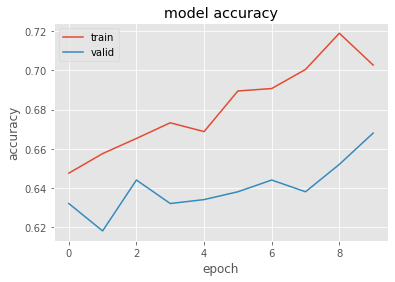

In [26]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [27]:
from tensorflow.keras.applications import Xception
Xception_base = Xception(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(64,64,3)))
Xception_base.trainable = False

head_model = FCHeadNet.build(Xception_base, 10, 256)
Xception_model = tf.keras.models.Model(inputs = Xception_base.input, outputs=head_model)

loss = CategoricalCrossentropy(label_smoothing=0.1)
opt = tf.keras.optimizers.RMSprop(lr=0.001)
Xception_model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])

In [28]:
X_history = Xception_model.fit(it,
          validation_data = (X_valid,y_valid_hot),
          callbacks=[earlystopping],
          epochs=10,
          batch_size = 32)

Epoch 1/10
250/250 [==============================] - 32s 127ms/step - loss: 1.9065 - accuracy: 0.4748 - val_loss: 1.5639 - val_accuracy: 0.6340
Epoch 2/10
250/250 [==============================] - 32s 129ms/step - loss: 1.5663 - accuracy: 0.5692 - val_loss: 1.3693 - val_accuracy: 0.6460
Epoch 3/10
250/250 [==============================] - 33s 131ms/step - loss: 1.4778 - accuracy: 0.6195 - val_loss: 1.3518 - val_accuracy: 0.6520
Epoch 4/10
250/250 [==============================] - 32s 129ms/step - loss: 1.4178 - accuracy: 0.6252 - val_loss: 1.3122 - val_accuracy: 0.6560
Epoch 5/10
250/250 [==============================] - 32s 128ms/step - loss: 1.3786 - accuracy: 0.6503 - val_loss: 1.3343 - val_accuracy: 0.6520
Epoch 6/10
250/250 [==============================] - 32s 128ms/step - loss: 1.3584 - accuracy: 0.6610 - val_loss: 1.3031 - val_accuracy: 0.6680
Epoch 7/10
250/250 [==============================] - 32s 129ms/step - loss: 1.3555 - accuracy: 0.6620 - val_loss: 1.2930 - val_ac

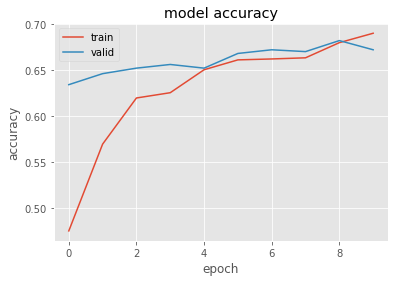

In [29]:

plt.plot(X_history.history['accuracy'])
plt.plot(X_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [79]:
chosen_model = Xception_model
chosen_model.evaluate(data_manager.X_test, y_test_hot, batch_size = 32)[1]

16/16 [==============================] - 3s 169ms/step - loss: 1.3394 - accuracy: 0.6560


0.656000018119812

In [9]:
def load_test_set(folder):
    from PIL import Image
    from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    image_paths = list(paths.list_images(folder))
    test_data = []
    for i, image_path in enumerate(image_paths):
        img = Image.open(image_path).convert("RGB") #load_img(image_path)
        img = img.resize((64, 64), Image.ANTIALIAS)
        x = img_to_array(img)
        x = x / 255
        test_data.append(x)
        if i+1 % 500 ==0:
            print("Loaded {} images".format(i+1))
    test_data = np.asarray(test_data)
    return test_data
test_data = load_test_set("official_test_aug")
print("Test shape: {}".format(test_data.shape))

Test shape: (23098, 64, 64, 3)


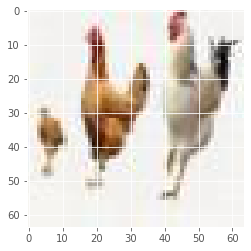

In [10]:
plt.imshow(test_data[0])

In [ ]:
categorical_labels = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'fish', 'horse', 'lion', 'spider']

results = np.zeros((test_data.shape[0],10))

for j in range(nets):
    print(j)
    results = results + model[j].predict(test_data)

num_predicted_labels = np.argmax(results, axis=1)
print(num_predicted_labels[0:15])

cat_predicted_labels= [categorical_labels[num_predicted_labels[i]] for i in range(len(num_predicted_labels))]
print(cat_predicted_labels[0:15])

In [17]:
#
categorical_labels = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'fish', 'horse', 'lion', 'spider']


preds = chosen_model.predict(test_data, batch_size = 32)

num_predicted_labels = np.argmax(preds, axis=1)
print(num_predicted_labels[0:15])

cat_predicted_labels= [categorical_labels[num_predicted_labels[i]] for i in range(len(num_predicted_labels))]
print(cat_predicted_labels[0:15])

KeyboardInterrupt: 

['chicken', 'lion', 'butterfly', 'dog', 'lion', 'lion', 'butterfly', 'cat', 'dog', 'chicken', 'cow', 'elephant', 'lion', 'dog', 'spider', 'cat', 'chicken', 'chicken', 'lion', 'dog', 'horse', 'lion', 'dog', 'cat', 'spider']


<Figure size 432x288 with 0 Axes>

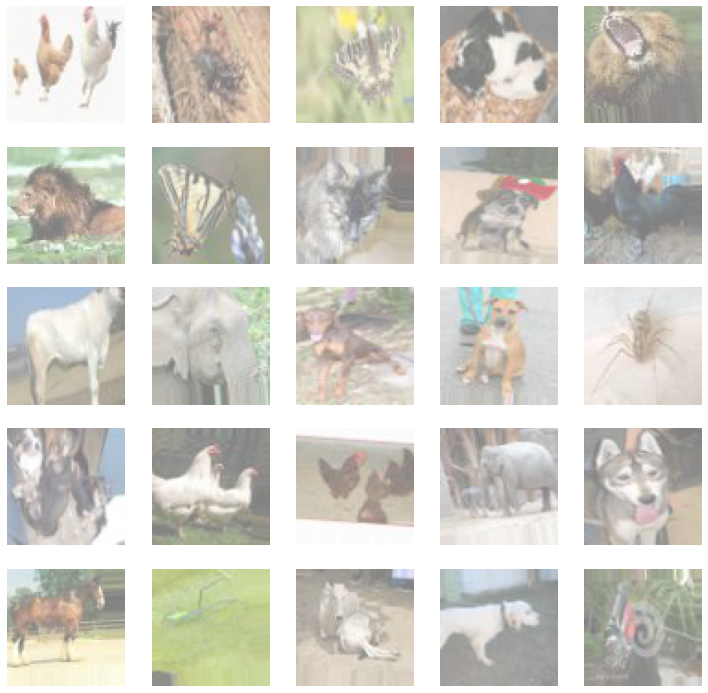

In [113]:
X = test_data[0:25]
print(cat_predicted_labels[0:25])
tile_shape = (5,5)

plt.clf()
fig, ax = plt.subplots(tile_shape[0], tile_shape[1], figsize=(2.5 * tile_shape[1], 2.5 * tile_shape[0]))

for i in range(tile_shape[0]):
    for j in range(tile_shape[1]):
        ax[i, j].imshow((X[i * tile_shape[1] + j] + 1.0)/2)
        ax[i, j].grid(False)
        ax[i, j].axis('off')
plt.show()

In [97]:
def create_solution():
    import csv
    header= ['ID', 'Label']
    with open('my_solution.csv', 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        # write the header
        writer.writerow(header)
        data = []
        for i in range(len(cat_predicted_labels)):
            data.append([str(i), cat_predicted_labels[i]])
        writer.writerows(data)
        
create_solution()